In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
def compute_iou(truth, output_classes, num_classes: int):
    class_count = 0
    iou = 0.0
    for c in range(num_classes):
        # Create tensors with 1 for every pixel labelled with this class, and 0 otherwise. We then
        # add these tensors. The result has 2 for the intersection, and 1 or 2 for the union.

        truth_for_class = torch.where(truth == c, torch.ones_like(truth, dtype=torch.int),
                                      torch.zeros_like(truth, dtype=torch.int))

        output_for_class = torch.where(output_classes == c, torch.ones_like(output_classes, dtype=torch.int),
                                       torch.zeros_like(output_classes, dtype=torch.int))

        result = truth_for_class + output_for_class
        # View in 1D as bincount only supports 1D.
        # We expect values 0, 1, 2 for no object, one object and both objects respectively.
        counts = torch.bincount(result.view(-1), minlength=3)

        assert counts.size(0) == 3, 'Wrong number of bins: {}'.format(counts)

        intersection = counts[2].item()
        union = counts[1].item() + counts[2].item()
        
        print(f'class={c}, intersection={intersection}, union={union}')

        if union > 0:
            class_count += 1
            iou += intersection / union

    return iou / class_count

Ground truth:

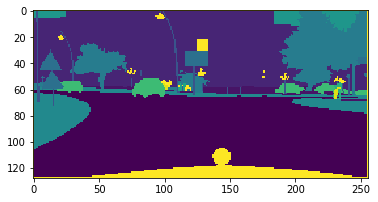

In [3]:
image = np.asarray(Image.open('../example-tiny-cityscapes/aachen/aachen_000000_000019_gtFine_labelIds.png')).copy()
image[image == 255] = 19
plt.imshow(image)

In [4]:
def rem255(a):
    return np.where(a != 255, a, np.zeros_like(a))

Ground truth downsampled to 16x32, the output size of the decoder:

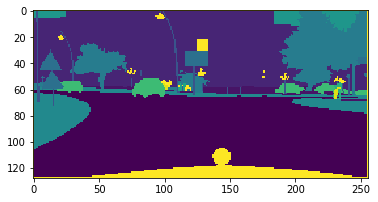

In [4]:
def to_one_hot(x):
    oh_x = np.zeros((20,) + x.shape)
    x_19 = image.copy()
    x_19[x_19 == 255] = 19
    # Convert to one hot
    oh_x[x_19, np.expand_dims(range(x.shape[0]), 1), np.expand_dims(range(x.shape[1]), 0)] = 1
    return oh_x

def from_one_hot(x):
    return np.argmax(x, axis=0)

test = from_one_hot(to_one_hot(image))
test[test == 19] = 255
np.unique(test == image)
plt.imshow(from_one_hot(to_one_hot(image)))

(16, 32)


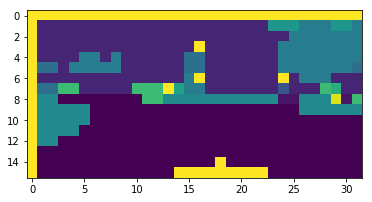

In [55]:
image_t = torch.tensor(image).unsqueeze(0).unsqueeze(0).float()
downsampled_t = F.interpolate(image_t, size=(16,32), mode='nearest')
downsampled = downsampled_t.numpy().squeeze()
print(downsampled.shape)
plt.imshow(downsampled)
# plt.imshow(from_one_hot(downsampled))

Upsample the image again, and compute the IOU

In [36]:
upsampled_t = F.interpolate(downsampled_t, size=(128,256), mode='bilinear') #, align_corners=False
upsampled_t = upsampled_t.round()
upsampled = upsampled_t.numpy().squeeze()

/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(20, 128, 256)

array([0., 1.], dtype=float32)

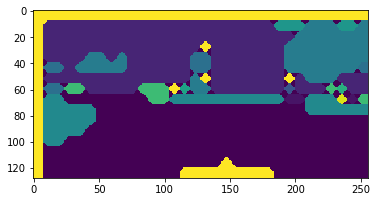

In [37]:
plt.imshow(from_one_hot(upsampled))
np.unique(upsampled)

In [43]:
# print(image_t.shape)
compute_iou(torch.argmax(image_t, dim=1), torch.argmax(upsampled_t, dim=1), 20)

class=0, intersection=11481, union=14425
class=1, intersection=19, union=605
class=2, intersection=7406, union=11112
class=3, intersection=0, union=0
class=4, intersection=0, union=0
class=5, intersection=2, union=366
class=6, intersection=0, union=0
class=7, intersection=272, union=756
class=8, intersection=2618, union=3852
class=9, intersection=1318, union=3087
class=10, intersection=133, union=714
class=11, intersection=15, union=48
class=12, intersection=12, union=62
class=13, intersection=281, union=870
class=14, intersection=0, union=0
class=15, intersection=0, union=0
class=16, intersection=0, union=0
class=17, intersection=0, union=0
class=18, intersection=0, union=75
class=19, intersection=1075, union=4932


0.32299451893435766

Directly optimise a 16x32 image so, when upscaled to 128x256, it matches the ground truth:

In [5]:
li = torch.rand(1, 20,16,32, requires_grad=True)
truth = torch.tensor(image).unsqueeze(0).long()

ce_loss = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam([li], lr=0.001)

losses = []
for i in range(30000):
    up = F.interpolate(li, size=(128,256), mode='bilinear')
    loss = ce_loss(up, truth)
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if i % 500 == 0:
        print(f'{i}: {loss}')
    
print('Done')

/Users/oscar/.local/share/virtualenvs/multitask-learning-gPiQRYl0/lib/python3.7/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0: 3.0073115825653076
500: 1.7423580884933472
1000: 0.870158314704895
1500: 0.46155744791030884
2000: 0.30699339509010315
2500: 0.2427070289850235
3000: 0.21227431297302246
3500: 0.19636209309101105
4000: 0.1871759593486786
4500: 0.18138593435287476
5000: 0.17703475058078766
5500: 0.1736767292022705
6000: 0.17091447114944458
6500: 0.1684494912624359
7000: 0.16615134477615356
7500: 0.1641867309808731
8000: 0.1625485122203827
8500: 0.16110938787460327
9000: 0.15989984571933746
9500: 0.15877562761306763
10000: 0.1576707810163498
10500: 0.15660886466503143
11000: 0.1557387411594391
11500: 0.15501350164413452
12000: 0.15430805087089539
12500: 0.15369881689548492
13000: 0.153193861246109
13500: 0.15275271236896515
14000: 0.15229007601737976
14500: 0.15185530483722687
15000: 0.15147832036018372
15500: 0.1511419415473938
16000: 0.15083903074264526
16500: 0.15055924654006958
17000: 0.15028929710388184
17500: 0.15005789697170258
18000: 0.14985297620296478
18500: 0.14963360130786896
19000: 0.1494

In [103]:
output = F.interpolate(li.clone().detach(), size=(128,256), mode='bilinear').squeeze().numpy()

(20, 128, 256)


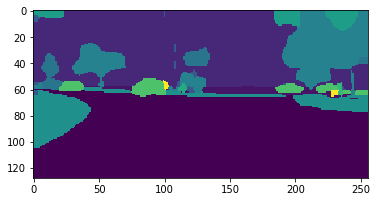

In [105]:
plt.imshow(rem255(output.argmax(0)))
plt.show()

In [128]:
compute_iou(truth, torch.tensor(output.argmax(0)), 20)

class=0, intersection=12823, union=14536
class=1, intersection=407, union=559
class=2, intersection=9243, union=10289
class=3, intersection=0, union=0
class=4, intersection=0, union=0
class=5, intersection=48, union=403
class=6, intersection=0, union=0
class=7, intersection=468, union=609
class=8, intersection=3259, union=3733
class=9, intersection=1945, union=2254
class=10, intersection=539, union=679
class=11, intersection=20, union=37
class=12, intersection=21, union=49
class=13, intersection=601, union=728
class=14, intersection=0, union=0
class=15, intersection=0, union=0
class=16, intersection=0, union=0
class=17, intersection=0, union=0
class=18, intersection=22, union=59
class=19, intersection=0, union=0


0.6744541768758298